In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'
import matplotlib as mpl
import numpy as np
import xarray as xr

sys.path.append('..')
%aimport project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


In [3]:
case = project.imaging.Emory4DCTCase(data_root='../data/Emory-4DCT', case_name='Case1Pack', phases=[0, 50])
case.load_niftis()
case.load_masks(roi=['lung_combined_mask', 'body'])
case

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz


Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 2 phases)

<IPython.core.display.Javascript object>


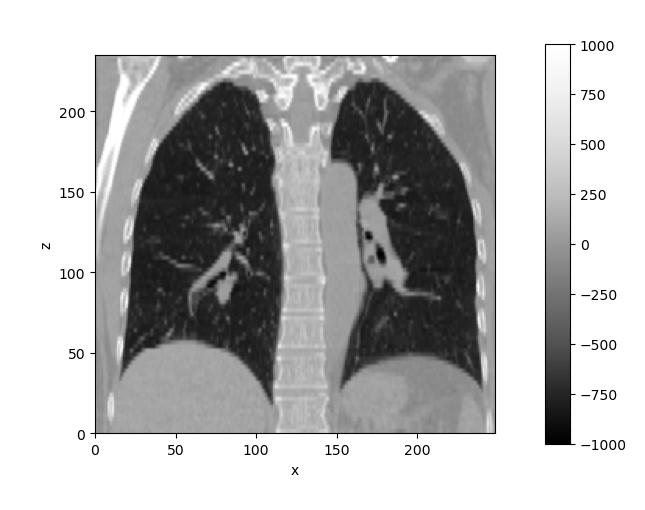

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

<IPython.core.display.Javascript object>


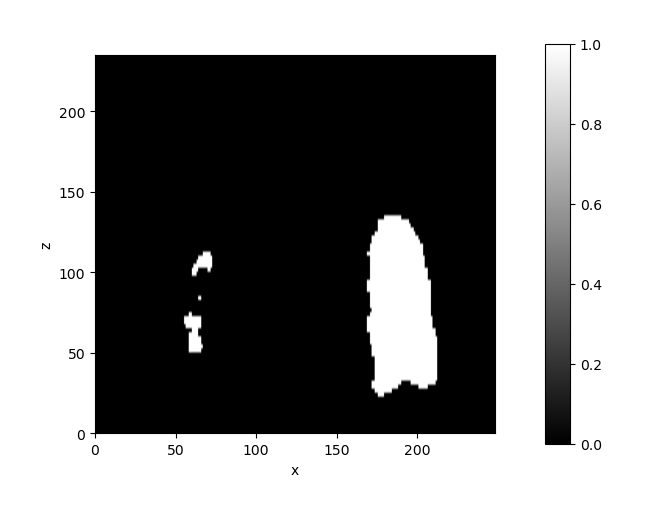

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (50, 1)), value=0), SelectionSlide…

In [4]:
%autoreload
project.visual.XArrayViewer(case.array, x='x', y='z', cmap='Greys_r', vmin=-1000, vmax=1000)
project.visual.XArrayViewer(case.mask,  x='x', y='z')

In [6]:
lung_mask = case.mask.sel(roi='lung_combined_mask')
lung_mask.shape

(2, 256, 256, 94)

In [7]:
phase_mask = lung_mask.sel(phase=0)
n_x, n_y, n_z = phase_mask.shape
n_x, n_y, n_z

(256, 256, 94)

In [8]:
def compute_height_percentile(lung_mask, p):
    n_x, n_y, n_z = lung_mask.shape

    # get z index range occupied by lung mask
    z_mask = lung_mask.max(['x', 'y']).values
    lung_bottom = z_mask.argmax()
    lung_top = n_z - z_mask[::-1].argmax()
    lung_range = lung_top - lung_bottom
    
    return lung_bottom + int(p * lung_range)

compute_height_percentile(phase_mask, p=1/3)

34

<IPython.core.display.Javascript object>


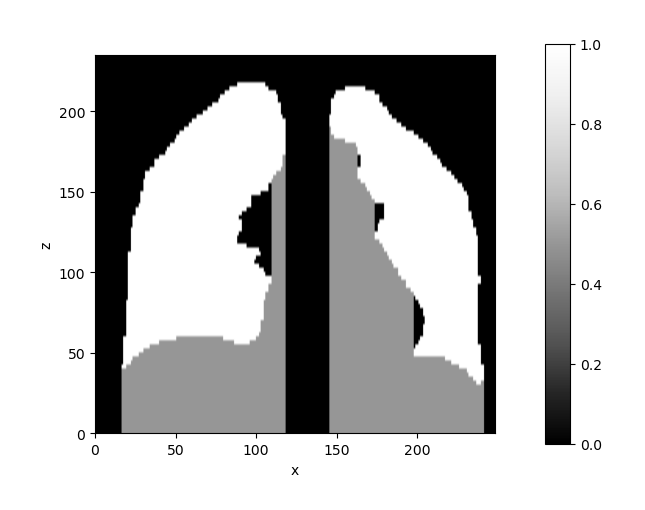

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


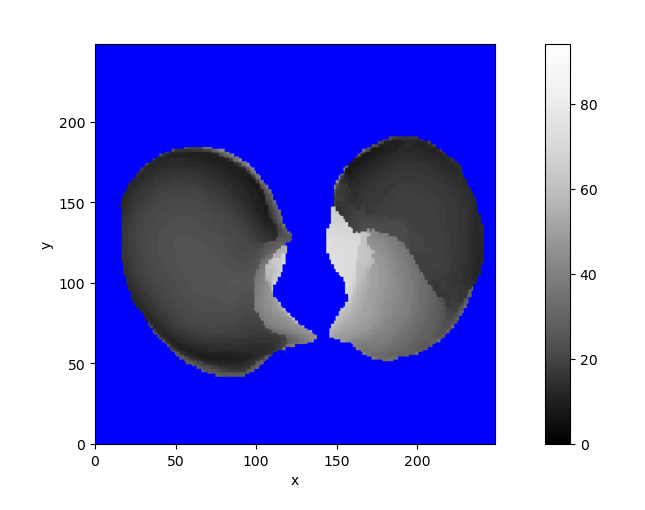

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [9]:
def compute_height_map(lung_mask, max_height):
    n_x, n_y, n_z = lung_mask.shape
    
    # select voxels in lung mask up to max height
    z_max = compute_height_percentile(lung_mask, max_height)

    lung_mask = lung_mask.copy()
    lung_mask[...,z_max:] = 0
    
    # compute downcasted lung mask
    # i.e. set of voxels that are BELOW and NOT ABOVE lung voxels    
    above_mask = lung_mask.rolling(z=n_z, min_periods=1).max()
    
    below_mask = lung_mask.reindex(z=lung_mask.z[::-1])
    below_mask = below_mask.rolling(z=n_z, min_periods=1).max()
    below_mask = below_mask.reindex(z=lung_mask.z)
    
    downcasted_mask = below_mask * (1 - above_mask)
    
    # convert downcasted mask to height_map
    height_map = downcasted_mask.sum('z')
    height_map = height_map.where(height_map > 0, np.nan)

    return downcasted_mask, height_map

downcasted_mask, height_map = compute_height_map(phase_mask, max_height=1.0)

greys_r = mpl.colormaps['Greys_r']
greys_r.set_bad('blue')

project.visual.XArrayViewer(phase_mask + downcasted_mask/2, x='x', y='z', cmap=greys_r, vmin=0, vmax=1)
project.visual.XArrayViewer(height_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=94)

<IPython.core.display.Javascript object>


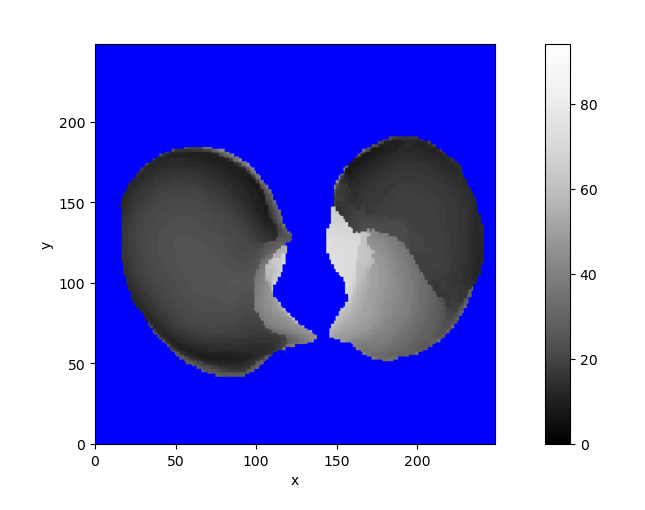

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


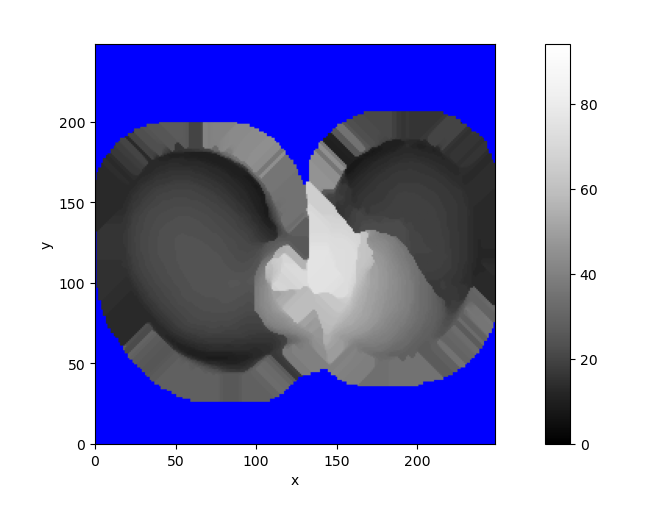

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


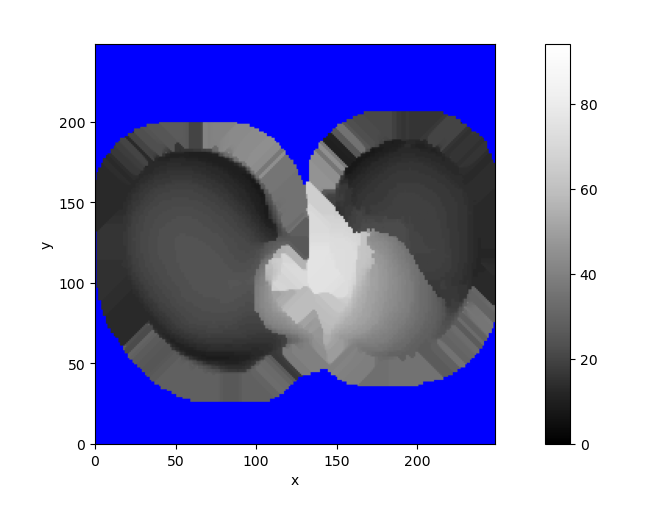

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


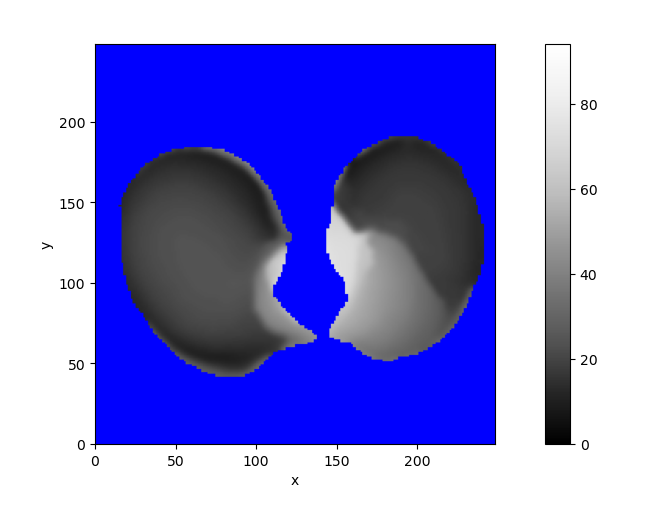

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [228]:
import skimage
import scipy

# smooth the height map

sigma = 2
truncate = 4
radius = np.round(truncate * sigma)

padding = radius * 2

padded_height_map = height_map.copy()
for i in range(padding):
    median_height_map = padded_height_map.rolling(x=3, y=3, center=True) \
        .construct(x='x_win', y='y_win').median(['x_win', 'y_win'], skipna=True)
    padded_height_map = height_map.where(height_map.notnull(), median_height_map)

smoothed_height_map = scipy.ndimage.gaussian_filter(padded_height_map, sigma=sigma, truncate=truncate) + 0 * height_map

project.visual.XArrayViewer(height_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=94)
project.visual.XArrayViewer(median_height_map, x='x', y='y',   cmap=greys_r, vmin=0, vmax=94)
project.visual.XArrayViewer(padded_height_map, x='x', y='y',   cmap=greys_r, vmin=0, vmax=94)
project.visual.XArrayViewer(smoothed_height_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=94)

<IPython.core.display.Javascript object>


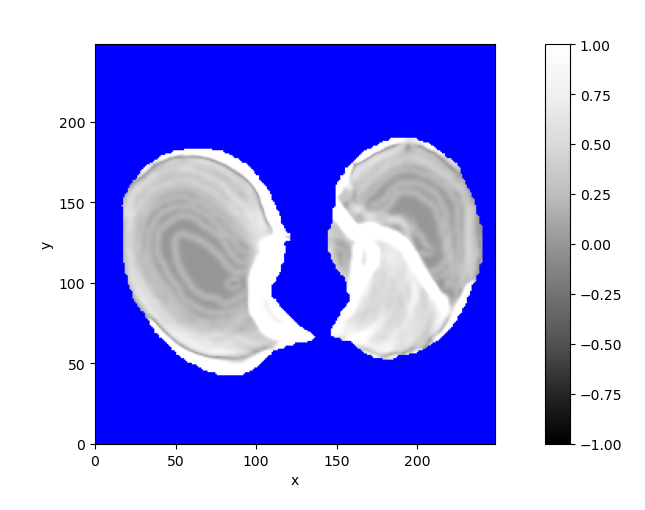

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


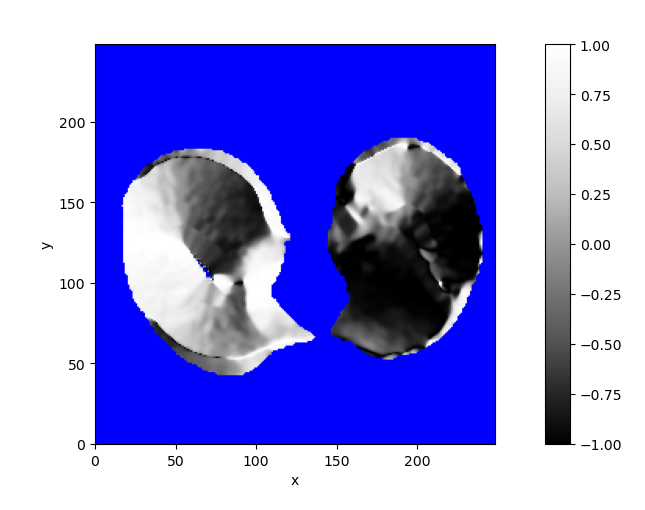

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


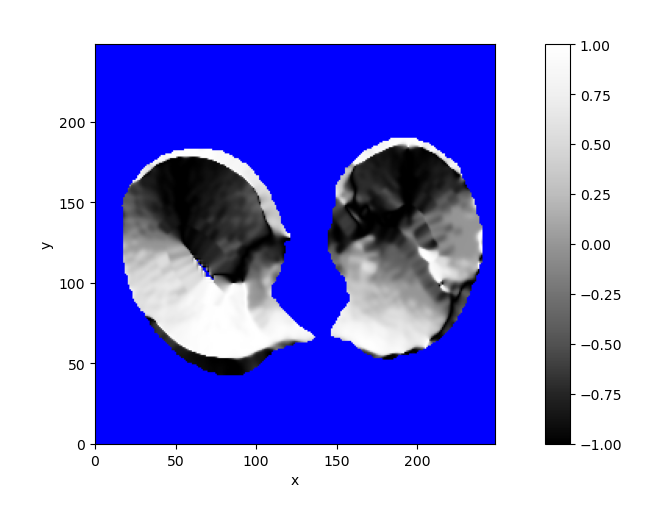

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


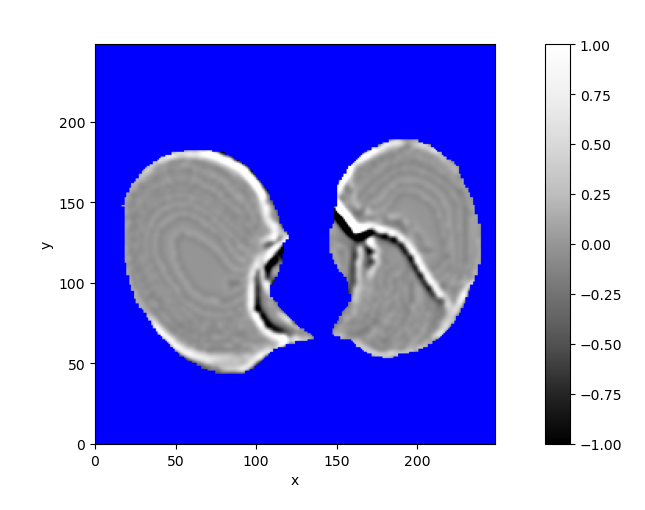

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


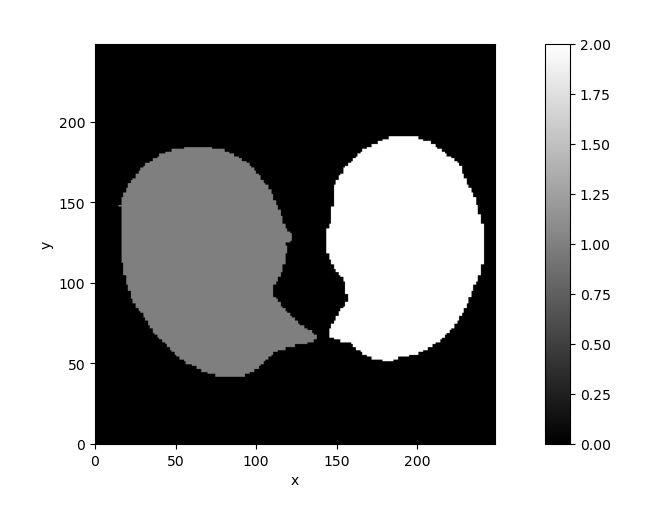

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [229]:
# compute gradient of inferior lung surface height map
dx = smoothed_height_map.differentiate('x', edge_order=1)
dy = smoothed_height_map.differentiate('y', edge_order=1)

grad_norm = (dx**2 + dy**2)**0.5
grad_cos = dx / grad_norm
grad_sin = dy / grad_norm

dxx = dx.differentiate('x', edge_order=1)
dxy = dx.differentiate('y', edge_order=1)
dyx = dy.differentiate('x', edge_order=1)
dyy = dy.differentiate('y', edge_order=1)

laplacian = dxx + dyy

lung_id_map = skimage.measure.label(height_map.notnull()) + height_map.notnull() * 0

project.visual.XArrayViewer(grad_norm, x='x', y='y', cmap=greys_r, vmin=-1, vmax=1)
project.visual.XArrayViewer(grad_cos,  x='x', y='y', cmap=greys_r, vmin=-1, vmax=1)
project.visual.XArrayViewer(grad_sin,  x='x', y='y', cmap=greys_r, vmin=-1, vmax=1)
project.visual.XArrayViewer(laplacian, x='x', y='y', cmap=greys_r, vmin=-1, vmax=1)
project.visual.XArrayViewer(lung_id_map, x='x', y='y', vmin=0, vmax=2)

In [230]:
# identify center of each lung's inferior surface

n_x, n_y = height_map.shape

xy = np.stack(np.meshgrid(
    np.arange(n_x),
    np.arange(n_y),
    indexing='ij'
), axis=-1).reshape(-1, 2)

lung_ids = lung_id_map.values.reshape(-1)
grad_norms = grad_norm.values.reshape(-1)
heights = height_map.values.reshape(-1)

tol = 1e-3
lung1_inds = (lung_ids == 1) & (grad_norms < tol)
lung2_inds = (lung_ids == 2) & (grad_norms < tol)

lung1_center = xy[lung1_inds].mean(axis=0)
lung2_center = xy[lung2_inds].mean(axis=0)

lung1_height = heights[lung1_inds].mean()
lung2_height = heights[lung2_inds].mean()

print(lung1_center, lung1_height)
print(lung2_center, lung2_height)

[ 68.68333333 112.26666667] 24.0
[207.21311475 146.80327869] 19.0


In [231]:
diaph_top = np.array([0, lung1_height + 1, lung2_height + 1], dtype=int)
diaph_top

array([ 0, 25, 20])

<IPython.core.display.Javascript object>


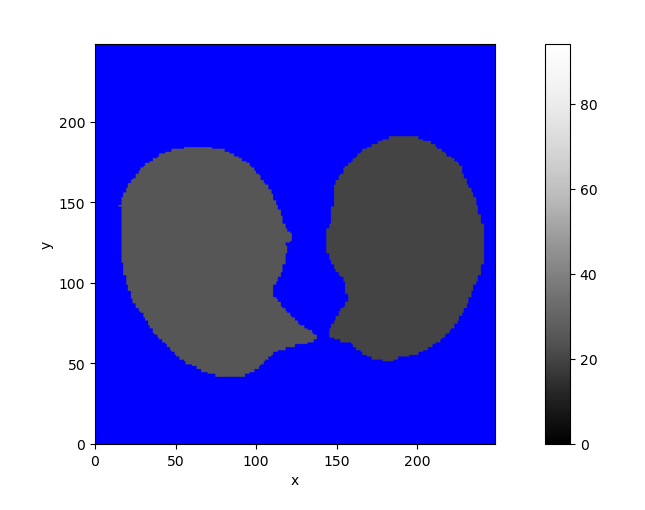

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [232]:
diaph_top_map = diaph_top[lung_ids].reshape(height_map.shape) + 0 * height_map
diaph_top_map = diaph_top_map.where(height_map.notnull(), np.nan)

project.visual.XArrayViewer(diaph_top_map, x='x', y='y', cmap=greys_r, vmax=94)

In [233]:
lung_center = np.stack([np.zeros(2), lung1_center, lung2_center], axis=0)
lung_center

array([[  0.        ,   0.        ],
       [ 68.68333333, 112.26666667],
       [207.21311475, 146.80327869]])

<IPython.core.display.Javascript object>


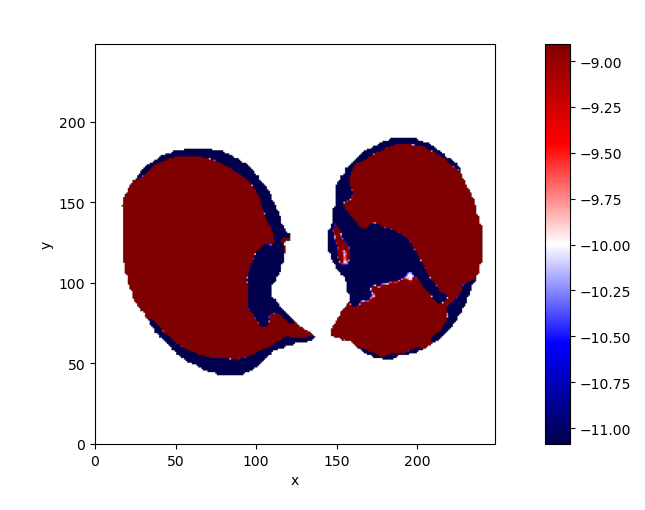

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [245]:
# compute angle to nearest lung center

center_diffs = lung_center[lung_ids] - xy
diff_norms = np.linalg.norm(center_diffs, axis=1)

dx_values = dx.values.reshape(-1)
dy_values = dy.values.reshape(-1)
grad_values = np.stack([dx_values, dy_values], axis=1)
grad_norms = np.linalg.norm(grad_values, axis=1)

angles = (grad_values * center_diffs).sum(axis=1) # / (grad_norms * diff_norms)
angle_map = angles.reshape(height_map.shape) + 0 * height_map

project.visual.XArrayViewer(angle_map, x='x', y='y', cmap='seismic', vmin=-100, vmax=100)

<IPython.core.display.Javascript object>


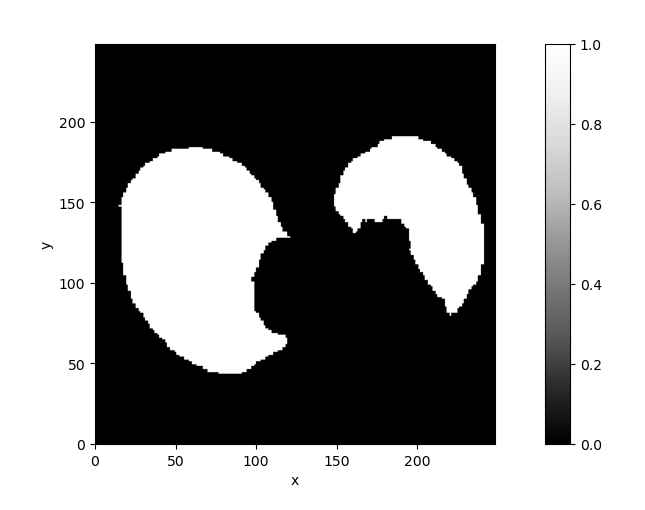

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


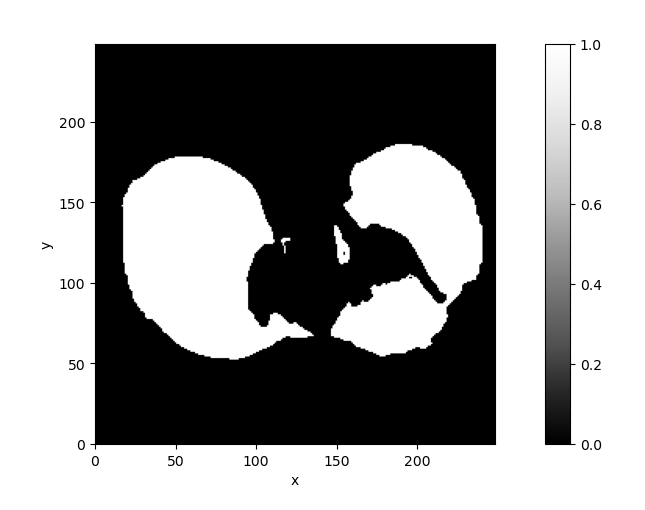

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


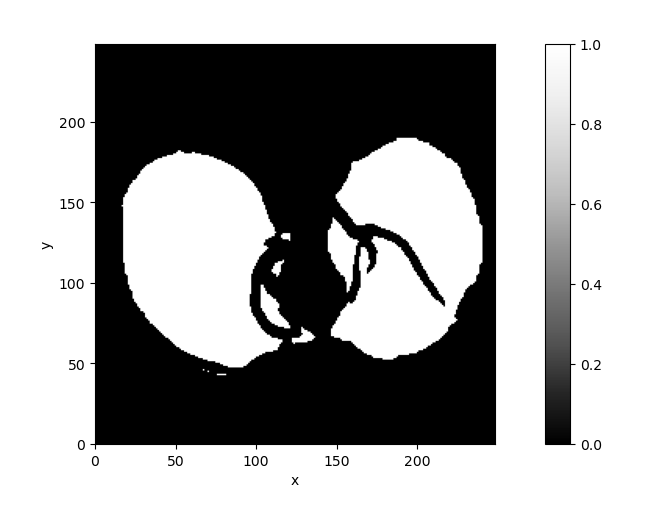

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


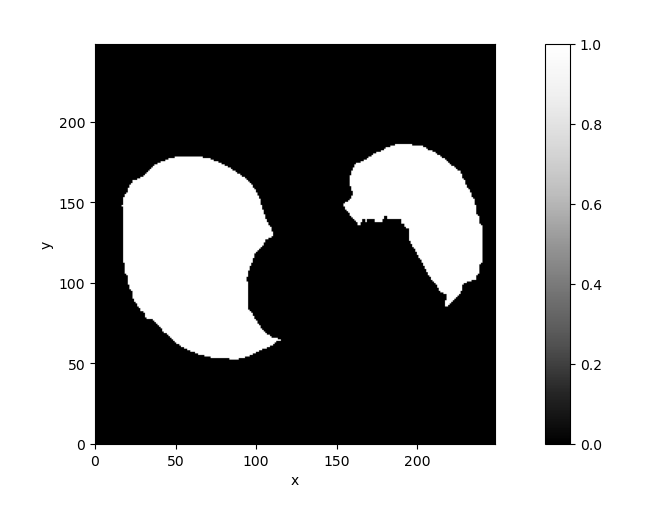

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


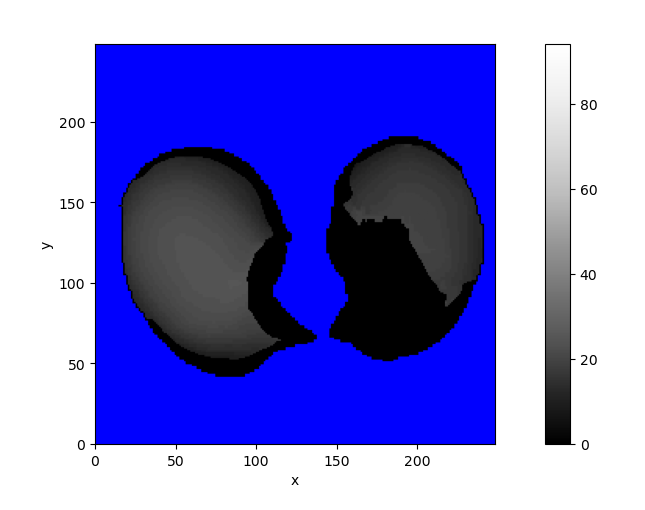

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


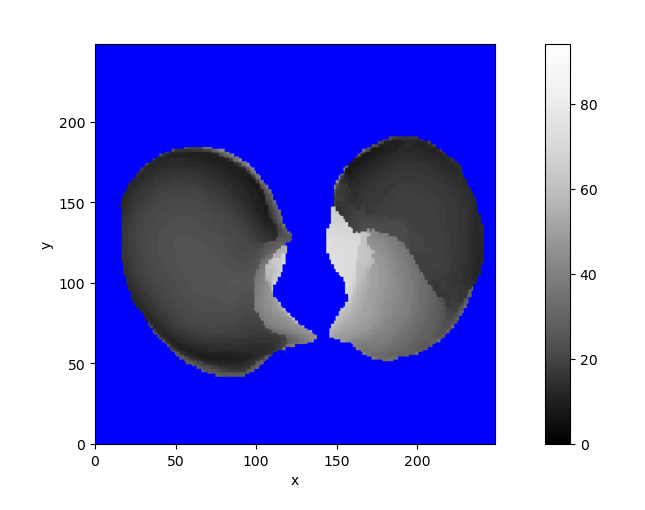

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [260]:
height_cond = (height_map <= diaph_top_map)
angle_cond  = (angle_map >= -10)
grad_cond = (grad_norm < 1.5)

diaph_map = (height_cond & angle_cond & grad_cond)

project.visual.XArrayViewer(height_cond, x='x', y='y', cmap=greys_r, vmin=0, vmax=1)
project.visual.XArrayViewer(angle_cond, x='x', y='y',  cmap=greys_r, vmin=0, vmax=1)
project.visual.XArrayViewer(grad_cond, x='x', y='y',  cmap=greys_r, vmin=0, vmax=1)

project.visual.XArrayViewer(diaph_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=1)
project.visual.XArrayViewer(diaph_map * height_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=94)
project.visual.XArrayViewer(height_map, x='x', y='y', cmap=greys_r, vmin=0, vmax=94)

<IPython.core.display.Javascript object>


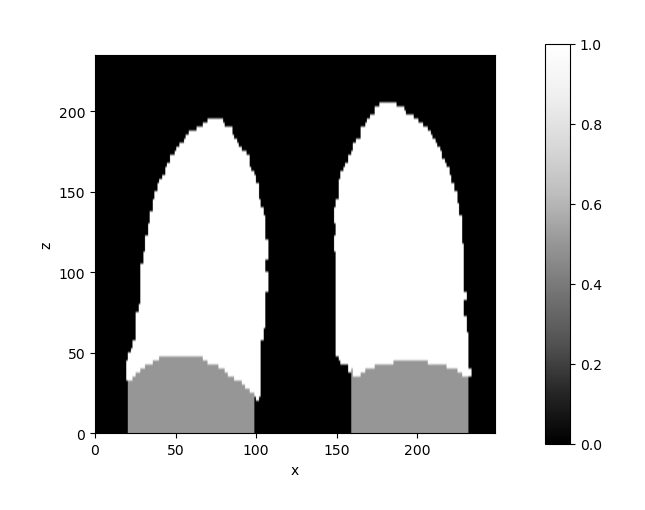

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [261]:
# convert to diaphragm mask

diaph_mask = phase_mask * 0

for i in range(n_z):
    diaph_mask.values[:,:,i] = ((height_map >= i) * diaph_map).astype(int)
    
project.visual.XArrayViewer(phase_mask + diaph_mask/2, x='x', y='z', cmap=greys_r, vmin=0, vmax=1)